# Probability and Statistics

Much of machine learning is also about uncertainty. In supervised learning, we hope to predict something unknown given something known (targets vs features). Models that are trained in this way attempt to predict the mostly likely value of a given target. Alternatively, these models may attempt to predict the value with the smallest expected distance from the target while also trying to *quantify our uncertainty*. 

With models under unsupervised learning, we especially care about uncertainty. We do so in order to determine whether a set of measurements are anomalous or to know how likely a set of values are in a given population. 

With reinforcement learning, the dream is to develop agents that can act intelligently under a variety of conditions and within a variety of environments. This presupposes a need to be able to reason about how an environment may be expected to change and what rewards a model might expect to encounter as result of a various possible actions it could take. 


**Probability** is the field of mathematics that covers all of these concerns vis a vis reasoning under uncertainity. The use of probabilities to describe the frequencies of repeatable events is pretty standard practice. Broadly speaking, **frequentists** adhere to an interpretation of probability that only applies to repeatable events. By contrast, **Bayesians** use the language of probability more broadly to formalize reasoning under uncertainty.

Bayesian probability is characterized by two unique features:

1) assigning degrees of belief to non-repreatable events e.g., "what is the *probability* that a dam will collapse?"

2) subjectivity. While Bayesian probability provides unambiguous rules for how one should update their beliefs in light of new evidence, it allows for different individuals to start off with different *prior* beliefs.

**Statistics** helps us to reason backwards, starting off with collection and organization of data and backing out to what inferences we might draw about the process that generated the data. Whenever we analye a dataset, hunting for patterns that we hope might characterize a broader population, we are employing statistical thinking. 

In [1]:
%matplotlib inline
import random
import torch
from torch.distributions.multinomial import Multinomial

## Starting off simply: Flipping Coins

Imagine that we plan to toss a coin and want to quantify how likely we are to see heads or tails. If the coin is *fair*, the both outcomes are equally likely. Moreover if we plan nto toss the coin *n* times then the fraction of heads that we *expect* to see should exactly match the *expected* fraction of tails. 

One intuitive way to see this is by symmetry. For every possible outcome with n<sub>h</sub> heads and n<sub>t</sub> = (n - n<sub>h</sub> tails, there is an equally likely outcome with n<sub>t</sub> heads and n<sub>h</sub> tails. Notice that this is only possible if on average we expect 1/2 of the tosses to come up heads and 1/2 to come up tails. In practice, if you conduct this experiment many times with n = 1000000 tosses each, you might never see a trial where n<sub>h</sub> = n<sub>t</sub> exactly. 

More formally, the quantity 1/2 is referred to as a **probability** and here it captures the certainty with which any given toss will come up heads. Probabilities assign scores between 0 and 1 to outcomes of interest, known as **events**. Here the event of interest is heads and we denote the corresponding probability *P*(heads). A probability of 1 indicates absolute certainty and a probability of 0 indicates impossibility. The frequencies n<sub>h</sub> / n and n<sub>t</sub> / n **are not probabilities but rather statistics**. 

**Probabilities are theoretical quantities** that underly the data generating process. In our example, the probability 1/2 is a property of the coin itself. By contrast, **statistics are imperical quantities** that are computed as functions of the observed data. Our interests in probabilistic and statistical quantities are inextricably intertwined. Specially designed statistics are called **estimators** that produce **estimates** of model parameters such as probabilities on a given dataset. 

Moreover, when those estimators satisfy a property called **consistency**, our estimates will converge to the corresponding probability. These inferred probabilities, in turn, tell us about the likely statistical properties of data from the same population that we might encounter in the future. 

Imagine that we found a real coin for which we did not know the true *P*(heads). To determine this quantity with statistical methods, we need to:

1) collect some data

2) design an estimator

Data aquisition here is easy since we can flip the coin many times and record all the outcomes. Formally, drawing realizations from some underlying random process is called **sampling**. As you might have guessed, one natural estimator is the ratio of the number of observed heads to the total number of tosses. 

Suppose that the coin was in fact fair, i.e., *P*(heads) = 0.5. To simulate tosses of a fair coin, we can invoke any random number generator. There are some easy ways to draw samples of an event with probability 0.5. For example Python's `random.random` yields number in the interval [0, 1] where the probability of lying in any sub-interval [a, b] ⊂ [0, 1] is equal to b - a. Thus we can get out 0 and 1 with probability 0.5 each by testing whether the returned float number is greater than 0.5:

In [2]:
num_tosses = 100
heads = sum([random.random() > 0.5 for _ in range(num_tosses)])
tails = num_tosses - heads 
print("heads, tails: ", [heads, tails])

heads, tails:  [63, 37]


More generally, we can simulate multiple draws from any variable with a finite number of possible outcomes (like the toss of a coin or roll of a die) by calling the multinomial function, setting the first argument to the number of draws and the second as a list of probabilities associated with each of the possible outcomes. To simulate ten tosses of a fair coin, we assign probability vector [0.5, 0.5], interpreting index 0 as heads and index 1 as tails. The function returns a vector with length equal to the number of possible outcomes (here, 2), where the first component tells us the number of occurrences of heads and the second component tells us the number of occurrences of tails. 

In [3]:
fair_probs = torch.tensor([0.5, 0.5])
Multinomial(100, fair_probs).sample()

tensor([47., 53.])

Each time you run this sampling process, you will receive a new random value that may differ from the previous outcome. Dividing by the number of tosses gives us the **frequency** of each outcome in our data. Note that these frequencies, just like the probabilities that they are intended to estimate, sum to 1. 

In [4]:
Multinomial(100, fair_probs).sample() / 100

tensor([0.4000, 0.6000])

Here, even though our simulated coin is fair (we ourselves set the probabilities [0.5, 0.5]), the counts of heads and tails may not be identical. That is because we only drew a relatively small number of samples. If we did not implement the simulation ourselves, and only saw the outcome, how would we know if the coin were slightly unfair or if the possible deviation from 1/2 was just an artifact of the small sample size? Let's see what happens when we simulate 10,000 tosses. 

In [5]:
counts = Multinomial(10000, fair_probs).sample()
counts / 10000

tensor([0.5020, 0.4980])

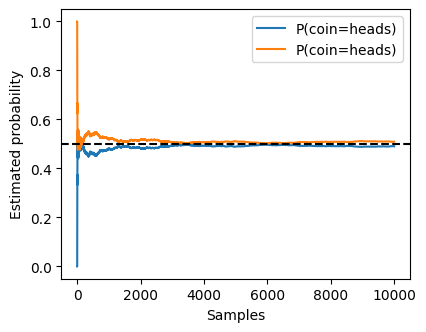

In [6]:
import matplotlib.pyplot as plt

counts = Multinomial(1, fair_probs).sample((10000,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
estimates = estimates.numpy()

plt.figure(figsize=(4.5, 3.5))
plt.plot(estimates[:, 0], label="P(coin=heads)")
plt.plot(estimates[:, 1], label="P(coin=heads)")
plt.axhline(y=0.5, color='black', linestyle='dashed')
plt.xlabel('Samples')
plt.ylabel('Estimated probability')
plt.legend()
plt.show()

Each solid curve corresponding to one of the two values of the coin and gives our estimated probability that the coin turns up that value after each group of experiments. The dashed black line gives the true underlying probability. As we get more data by conducting more experiments, the curves converge towards the true probability. You might already begin to see the shape of some of the more advanced questions that preoccupy statisticians: How quickly does this convergence happen? If we had already tested many coins manufactured at the same plant, how might we incorporate this information?

## A More Formal Treatment 

We have already gotten pretty far: posing a probabilistic model, generating synthetic data, running a statistical estimator, empirically assessing convergence, and reporting error metrics (checking the deviation). However, to go much further, we will needs to be more precise. 

When dealing with randomness, we denote the set of possible outcomes S and call it the **sample space** or **outcome space**. Here, each element is a distinct possible **outcome**. In the case of flipping a single coin, S = {heads,tails}. For a single die, S = {1,2,3,4,5,6}. When flipping two coins, possible outcomes are {(heads,heads),(heads,tails),(tails,heads),(tails,tails)}. **Events** are subsets of the sample space. For instance, the event "the first coin toss comes up heads" corresponds to the set {(heads,heads),(heads,tails)}. Whenever the outcome *z* of a random experiment statisfies *z* ∈ A, then event A has occurred. For a single roll of a die, we could define the events "seeing a 5" (A = {5}) and "seeing an odd number" (B = {1,3,5}). In this case, if the die came up 5, we would say that both A and B occurred. On the other hand, if *z* = 3, then A did not occur but B did. 

A **probability function** maps events onto real values *P*: A ⊆ S --> [0,1]. The probability, denoted *P*(A), of an event A in a given sample space S, has the following properties:

1) The probability of an event A is a nonnegative real number, i.e., *P*(A) ≥ 0;
   
2) The probability of the entire sample spaces is 1, i.e., *P*(S) = 1

3) For any countable sequence of events A<sub>1</sub>,A<sub>2</sub>, . . .that are **mutually exclusive** (i.e., A<sub>i</sub> ∩ A<sub>j</sub> = 0 for all i ≠ j), the probability that any of them happens is equal to the sum of their individual probabilities, i.e., *P*(U<sup>∞</sup><sub>i=1</sub> A<sub>i</sub>) = Σ<sup>∞</sup><sub>i=1</sub> *P*(A<sub>i</sub>).


These axioms of probability theory, proposed by Kolmogorov (1933), can be applied to rapidly derive a number of important consequences. For instance, it follows immediately that the probability of any event A *or* its complement A' occuring is 1 (because A U A' = S). We can also prove that *P*(0) = 0 because 1 = *P*(S U S') = *P*(S U 0) = *P*(S) + P(0) = 1 + *P*(0). Consequently, the probability of any event A *and* its complement A' occuring simultaneously is *P*(A ∩ A') = 0. Informally, this tells us that impossible events have zero probability of occurring. 

## Random Variables

When we spoke about events like the roll of a die coming up odds or the first coin toss coming up heads, we were invoking the idea of a **random variable**. Formally, random variables are mappings from an underlying sample space to a set of (possibly many) values. You might wonder how a random variable is different from the sample space, since both are collections of outcomes. Importantly, random variables can be much coarser than the raw sample space. We can define random variable like "greater than 0.5" even when the underlying sample space is infinite, e.g., points on the line segment between 0 and 1. 

Additionally, multiple random variables can share the same underlying sample space. For example “whether my home alarm goes off” and “whether my house was burgled” are both binary random variables that share an underlying sample space. Consequently, knowing the value taken by one random variable can tell us something about the likely value of another random variable. Knowing that the alarm went off, we might suspect that the house was likely burglarized. 

Every value taken by a random variable corresponds to a subset of the underlying sample space. Thus the occurrence where the random variable *X* takes value v, denoted by *X* = v, is an **event** and *P*(*X* = v) denotes its probability. Sometimes this notation can get clunky, and we can exploit notation when the context is clear. For example, we might use *P*(X), as a shorthand to express a statement that is true for all of the values that the random variables *X* and *Y* can take, i.e., for all *i*, *j* it holds that *P*(*X* = i and *Y* = j) = *P*(*X* = i)*P*(*Y* = j). 

Other times, we exploit the notation by writing *P*(v) when the random variable is clear from the context. Since an event in probability theory is a set of outcomes from the sample space, we can specify a range of values for a random variable to take. For example, *P*(1 ≤ *X* ≤ 3) denotes the probability of the event {1 ≤ *X* ≤ 3}. 

Notice that there is a subtle difference between **discrete** random variables, like flips of a coin or tosses of a die, and **continuous** ones, like the weight and the height of a person sampled at random from the population. In this scenario, we seldom really care about someone's exact height. What's more, if we took precise enough measurements, we would find that exceedingly few two people on the planet have the exact same height. In fact, with fine enough measurements, you would never have the same height when you wake up and when you go to sleep. There's practically no point in asking about the exact probability that someone is 1.801392782910287192 meters tall. Instead, we typically care more about being able to say whether someone's height falls into a given interval, say between 1.79 and 1.81 meters. In these cases we work with **probability densities**. The height of exactly 1.80 meters has no probability, but nonzero density. To work out the probability assigned to an interval, we must take an **integral** of the density over the that interval. 

## Multiple Random Variables

Most of machine learning is concerned with relationships like *P*(*X*,*Y*) = *P*(*X*)*P*(*Y*)). Here, the sample space would be the population of  interest, say customers who transact with a business, photographs on the internet, or proteins known to biologists. Each random variable would represent the (unknown) value of a different attribute. Whenever we sample an individual from the population, we observe a realization of each of the random variables. Because the values taken by random variables correspond to subsets of the sample space that could be overlapping, partially overlapping, or entirely disjointed, knowing the value taken by one random variable can cause us to update our beliefs about which values of another random variable are likely.

If a patient walks into a hospital and we observe that they are having trouble breathing and have lost their sense of smell, then we believe that they are more likely to have COVID-19 than we might if they had no trouble breathing and a perfectly ordingary sense of smell. When working with multiple random variables, we can construct events corresponding to every combination of values that the variables can jointly take. The probability function that assigns probabilities to each of these combintations (e.g., *A* = *a* and *B* = *b*) is called the **joint probability** function and simply returns the probability assigned to the intersection of the corresponding subsets of the sample space. The **joint probability** assigned to the event where random variables *A* and *B* take values *a* and *b*, respectively, is denoted *P*(*A* = *a*,*B* = *b*), where the comma indicates "and". 

Notice that for any values *a* and *b*, it follows that *P*(*A* = *a*,*B* = *b*) ≤ *P*(*A* = *a*) and *P*(*A* = *a*,*B* = *b*) ≤ *P*(*B* = *b*), since *A* = *a* and *B* = *b* to happen, *A* = *a* has to happen **and** *B* = *b* also has to happen. Interestingly enough, the joint probability tells us all that we can know about these random variables in a probabilistic sense, and can be used to derive many other useful quantities, including recovering the individual distributions *P*(*A*) and *P*(*B*). To recover *P*(*A* = a) we simply sum up *P*(*A* = *a*,*B* = *b*) over all values of *v* that the random variable *B* can take: *P*(*A* = *a*) = Σ<sub>v</sub>*P*(*A* = *a*,*B* = *b*). 

The ratio ((*A* = *a*,*B* = *b*) / *P*(*A*=*a*)) ≤ 1 turns out to be extremely important. It is called **the conditional probability**, and is denoted via the "|" symbol: *P*(*B* = *b* | *A* = *a*) = *P*(*A* = *a*,*B* = *b*)/*P*(*A* = *a*). It tells us the new probability associated with the event *B* = *b*, once we condition on the fact *A* = *a* took place. We can think of this conditional probability as restricting attention only to the subset of the sample space associated with *A* = *a* and then renormalizing so that all probabilities sum to 1. Conditional probabilities are in fact just ordinary probabilities and thus respect all of the axioms, as long as we condition all terms on the same event and thus restrict attention to the same sample space. 

For instance, for disjoint events B and B', we have that *P*(B u B' | *A* = *a*) = *P*(B | *A* = *a*) + *P*(B' | *A* = *a*). Using the definition of conditional probabilities, we can derive the famous result called **Bayes' theorem**. By construction, we have that *P*(A,B) = *P*(*B* | *A*)*P*(*A*) and *P*(*A*,*B*) = *P*(*A* | *B*)*P*(*B*). Combining both equations yields *P*(*B* | *A*)*P*(*A*)= *P*(*A* | *B*)*P*(*B*) and hence: *P*(*A* | *B*) = (*P*(*B* | *A*)*P*(*A*) / *P*(*B*))

This simple equation has profound implications because it allowsus to reverse the order of conditioning. If we know how to estimate *P*(*B* | *A*), *P*(*A*), and *P*(*B*), then we can estimate *P*(*A* | *B*). We often find it easier to eastimate one term directly but not the other and Bayes' theorem can come to the rescue here. For example, if we know the prevalence of symptoms for a given disease, and the overall prevalences of the disease and symptoms, respectively, we can determine how likely someone is to have the disease based on their symptoms. 

In some cases we might not have direct access to *P*(*B*), such as the prevalence of symptoms. In this case a simplified version of Bayes' theorem comes in handy: *P*(*A* | *B*) ∝ *P*(*B* | *A*)*P*(*A*). Since we know that *P*(*A* | *B*) must be normalized to 1, i.e.   Σ<sub>a</sub>*P*(*A* = *a* | *B*) = 1, we can use it to compute *P*(*A* | *B*) = (*P*(*B* | *A*)*P*(*A*) / Σ<sub>a</sub>*P*(*B* | *A* = *a*)*P*(*A* = *a*))

In Bayesian statistics, we think of an observer as possessing some *subjective* prior beliefs about the plausibility of the available hypotheses encoded in the *prior* *P*(*H*), and a **likelihood function** that says how likely one is to observe any value of the collected evidence for each of the hypotheses in the class *P*(*E* | *H*). Bayes' theorem is then interpreted as telling us how to update the initial *prior* *P*(*H*) in light of the available evidence *E* to produce **posterior** beliefs *P*(*H* | *E*) = (*P*(*E* | *H*)*P*(*H*) / *P*(*E*). Informally, this can be state as "posterior equals prior times likelihood, divided by the evidence". Now, because the evidence *P*(*E*) is the same for all hypotheses, we can get away with simply normalizing over the hypotheses. 

Notice that Σ<sub>a</sub>*P*(*A* = *a* | *B*) = 1 also allows us to **marginalize** over random variables. That is to say, we can drop variables from a joint distribution such as *P*(*A*,*B*). After all, we have that Σ<sub>a</sub>*P*(*B* | *A* = *a*)*P*(*A* = *a*) = Σ<sub>a</sub>*P*(*B*,*A* = *a*) = *P*(*B*,*A* = *a*) = *P*(*B*). 

**Independence** is another fundamentally important concept that forms the backbone of many important ideas in statistics. In short, two variables are independent if conditioning on the value of *A* does not cause any change to the probability distribution associated with *B* and vice versa. 